## Imports

In [20]:
from pathlib import Path
import re
import json
import hashlib
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import joblib

import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from urllib.parse import urlparse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Setup

In [4]:
PROJECT_ROOT = Path(".")
DATASETS_ROOT = Path("../dataset-creation")
PATHS = {
    "afp": DATASETS_ROOT / "AFP" / "out_afp_verificat" / "afp_verificat_dataset.csv",
    "factual": DATASETS_ROOT / "Factual" / "data" / "factual_ro_dataset_postprocessed.csv",
    "veridica": DATASETS_ROOT / "Veridica" / "data_veridica" / "veridica_dataset.csv",
    "ocr": DATASETS_ROOT / "Pseudo-FakeRom" / "ocr_fake_news_dataset.csv",
}

for k, p in PATHS.items():
    print(f"{k:8s} -> exists={p.exists()}  path={p}")

afp      -> exists=True  path=..\dataset-creation\AFP\out_afp_verificat\afp_verificat_dataset.csv
factual  -> exists=True  path=..\dataset-creation\Factual\data\factual_ro_dataset_postprocessed.csv
veridica -> exists=True  path=..\dataset-creation\Veridica\data_veridica\veridica_dataset.csv
ocr      -> exists=True  path=..\dataset-creation\Pseudo-FakeRom\ocr_fake_news_dataset.csv


## Utils

In [6]:
def normalize_ws(s: str) -> str:
    return " ".join((s or "").split())

def normalize_label(s: str) -> str:
    return normalize_ws(s).upper()

def md5(s: str) -> str:
    import hashlib
    return hashlib.md5((s or "").encode("utf-8")).hexdigest()

def safe_str(x) -> str:
    import numpy as np
    return "" if x is None or (isinstance(x, float) and np.isnan(x)) else str(x)

TRUE_SET_RO = {"ADEVĂRAT", "ADEVARAT", "PARȚIAL ADEVĂRAT", "PARTIAL ADEVARAT", "PARTIAL ADEVĂRAT"}
FALSE_SET_RO = {
    "FALS", "TRUNCHIAT", "INȘELĂTOR", "INSELATOR", "CONTEXT LIPSĂ", "CONTEXT LIPSA",
    "LIPSA CONTEXTULUI", "FOTOGRAFIE ALTERATĂ", "FOTOGRAFIE ALTERATA",
    "VIDEOCLIP ALTERAT", "VIDEO ALTERAT", "DEEPFAKE", "SATIRĂ", "SATIRA", "FARSĂ", "FARSA"
}
UNVERIFIABLE_SET_RO = {"IMPOSIBIL DE VERIFICAT", "S-A RĂZGÂNDIT", "S-A RAZGANDIT"}

def map_label_binary(label_fine: str):
    L = normalize_label(label_fine)
    if L in TRUE_SET_RO:
        return 1
    if L in FALSE_SET_RO:
        return 0
    if L in UNVERIFIABLE_SET_RO:
        return None
    if L in {"REAL", "TRUE"}:
        return 1
    if L in {"FAKE", "FALSE", "FABRICATED", "PROPAGANDA", "SATIRE", "FAKE NEWS", "DEZINFORMARE"}:
        return 0
    return None

def get_domain(u: str) -> str:
    u = safe_str(u).strip()
    if not u:
        return ""
    try:
        d = urlparse(u).netloc.lower()
        return d.replace("www.", "")
    except Exception:
        return ""

def load_afp(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "afp"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = df.get("source_url", "")
    out["source_domain"] = out["source_url"].fillna("").apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label_norm", df.get("label", "")).fillna("").apply(safe_str)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["text_long"] = ""
    out["y"] = out["label_fine"].apply(map_label_binary)
    return out

def load_factual(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "factual"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = df.get("source", df.get("speaker_url", "")).fillna("").apply(safe_str)
    out["source_domain"] = out["source_url"].apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["y"] = out["label_fine"].apply(map_label_binary)
    return out

def load_veridica(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "veridica"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = df.get("url", "")
    out["source_url"] = ""
    out["source_domain"] = out["url"].fillna("").apply(get_domain)
    out["title"] = df.get("title", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["claim"] = df.get("claim", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = (out["title"].where(out["title"].str.len()>0, out["claim"]) + " [SEP] " + out["claim"]).str.strip()
    out["y"] = 0
    return out

def load_ocr(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="utf-8")
    out = pd.DataFrame()
    out["dataset"] = "ocr"
    out["id"] = df.get("id", pd.Series([None]*len(df))).astype(str)
    out["url"] = ""
    out["source_url"] = ""
    out["source_domain"] = ""
    out["title"] = ""
    out["claim"] = ""
    out["label_fine"] = df.get("label", "").fillna("").apply(safe_str)
    out["text_long"] = df.get("text", "").fillna("").apply(safe_str).apply(normalize_ws)
    out["text_short"] = ""
    if "label_group" in df.columns:
        lg = df["label_group"].fillna("").apply(safe_str).str.upper()
        out["y"] = lg.map({"REAL": 1, "TRUE": 1, "FAKE": 0, "FALSE": 0})
    else:
        out["y"] = out["label_fine"].apply(map_label_binary)
    return out

## Load and standardize each dataset

In [7]:
dfs = []
if PATHS["afp"].exists():
    dfs.append(load_afp(PATHS["afp"]))
if PATHS["factual"].exists():
    dfs.append(load_factual(PATHS["factual"]))
if PATHS["veridica"].exists():
    dfs.append(load_veridica(PATHS["veridica"]))
if PATHS["ocr"].exists():
    dfs.append(load_ocr(PATHS["ocr"]))

data = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
print("Unified rows:", len(data))
data.head(3)

Unified rows: 2095


,dataset,id,url,source_url,source_domain,title,claim,label_fine,text_short,text_long,y
0,NaN,ec5256cca1a28dddab1e6bcea06d7698042da8cb,https://verificat.afp.com/doc.afp.com.32AD84J,https://www.facebook.com/mariana.muntean/posts...,facebook.com,Această înregistrare video nu este o dovadă că...,Acest videoclip arată că aterizarea pe Lună a ...,CONTEXT LIPSĂ,Această înregistrare video nu este o dovadă că...,,0.0
1,NaN,4010817634d8d58df5de9d932abace7d2a8ec2f5,https://verificat.afp.com/doc.afp.com.32BY897,https://www.facebook.com/Lupul.Dacic.blog/post...,facebook.com,Focarele de variola maimuței nu sunt legate de...,Variola maimuței este provocată de vaccinul As...,CONTEXT LIPSĂ,Focarele de variola maimuței nu sunt legate de...,,0.0
2,NaN,d11422ae41ff6c23d485c27ccc49b8b1a8e55d88,https://verificat.afp.com/doc.afp.com.32CX3EH,https://www.facebook.com/permalink.php?story_f...,facebook.com,Videoclipul care arată o „păpușă Ken însărcina...,"Aceasta este o nouă păpușă Ken, care este însă...",SATIRĂ,Videoclipul care arată o „păpușă Ken însărcina...,,0.0


## Quick schema check

In [8]:
print("Unified rows:", len(data))
print("Columns:", list(data.columns))
display(data.head(5))

display(data.dtypes)

Unified rows: 2095
Columns: ['dataset', 'id', 'url', 'source_url', 'source_domain', 'title', 'claim', 'label_fine', 'text_short', 'text_long', 'y']


,dataset,id,url,source_url,source_domain,title,claim,label_fine,text_short,text_long,y
0,NaN,ec5256cca1a28dddab1e6bcea06d7698042da8cb,https://verificat.afp.com/doc.afp.com.32AD84J,https://www.facebook.com/mariana.muntean/posts...,facebook.com,Această înregistrare video nu este o dovadă că...,Acest videoclip arată că aterizarea pe Lună a ...,CONTEXT LIPSĂ,Această înregistrare video nu este o dovadă că...,,0.0
1,NaN,4010817634d8d58df5de9d932abace7d2a8ec2f5,https://verificat.afp.com/doc.afp.com.32BY897,https://www.facebook.com/Lupul.Dacic.blog/post...,facebook.com,Focarele de variola maimuței nu sunt legate de...,Variola maimuței este provocată de vaccinul As...,CONTEXT LIPSĂ,Focarele de variola maimuței nu sunt legate de...,,0.0
2,NaN,d11422ae41ff6c23d485c27ccc49b8b1a8e55d88,https://verificat.afp.com/doc.afp.com.32CX3EH,https://www.facebook.com/permalink.php?story_f...,facebook.com,Videoclipul care arată o „păpușă Ken însărcina...,"Aceasta este o nouă păpușă Ken, care este însă...",SATIRĂ,Videoclipul care arată o „păpușă Ken însărcina...,,0.0
3,NaN,0bec94714c3eb4748a26d47bd54421d0cf24777a,https://verificat.afp.com/doc.afp.com.32DE2E4,https://www.facebook.com/groups/68539336570890...,facebook.com,O ilustrație a unui artist este prezentată gre...,Aceasta este cea mai detaliată imagine de până...,ÎNȘELĂTOR,O ilustrație a unui artist este prezentată gre...,,NaN
4,NaN,41ad3f20dff67d42466e9767027b15b25fae9bfd,https://verificat.afp.com/doc.afp.com.32J86CJ,https://www.facebook.com/petcu.mariana.92/post...,facebook.com,O „declarație mondială” care neagă urgența cli...,"1,200 de experți susțin că nu există o urgență...",CONTEXT LIPSĂ,O „declarație mondială” care neagă urgența cli...,,0.0


dataset           object
id                object
url               object
source_url        object
source_domain     object
title             object
claim             object
label_fine        object
text_short        object
text_long         object
y                float64
dtype: object

In [9]:
missing = data.isna().mean().sort_values(ascending=False)
display(pd.DataFrame({"missing_rate": missing, "missing_count": data.isna().sum()}))

,missing_rate,missing_count
claim,0.000000,0
dataset,1.000000,2095
id,0.000000,0
label_fine,0.000000,0
source_domain,0.000000,0
source_url,0.000000,0
text_long,0.000000,0
text_short,0.000000,0
title,0.000000,0
url,0.000000,0


In [10]:
print("Rows per dataset:")
display(data["dataset"].value_counts(dropna=False))

print("\nFine label distribution (top 30):")
display(data["label_fine"].fillna("NA").value_counts().head(30))

print("\nBinary y distribution (including NaN):")
display(data["y"].value_counts(dropna=False))

Rows per dataset:


dataset
NaN    2095
Name: count, dtype: int64


Fine label distribution (top 30):


label_fine
FAKE NEWS               508
REAL                    308
PROPAGANDĂ DE RĂZBOI    307
DEZINFORMARE            206
PROPAGANDA              157
FALS                    153
SATIRE                  131
FABRICATED              120
PLAUSIBLE                78
                         24
ADEVĂRAT                 22
ÎNȘELĂTOR                20
TRUNCHIAT                20
PARȚIAL ADEVĂRAT         19
CONTEXT LIPSĂ             6
FALSE                     4
FAKE-NEWS                 2
PROPAGANDĂ                2
1                         2
SATIRĂ                    1
FALSIFICAT                1
VIDEOCLIP FALSIFICAT      1
LIPSEȘTE CONTEXTUL        1
ÎNŞELĂTOR                 1
PARȚIAL FALS              1
Name: count, dtype: int64


Binary y distribution (including NaN):


y
0.0    1641
1.0     427
NaN      27
Name: count, dtype: int64

## Binary data only

In [11]:
if len(data) == 0:
    raise RuntimeError("No data loaded. Check PROJECT_ROOT and PATHS.")

data["text_long"] = data["text_long"].fillna("").astype(str)
data["text_short"] = data["text_short"].fillna("").astype(str)

def choose_input(row) -> str:
    tl = row["text_long"]
    ts = row["text_short"]
    if isinstance(tl, str) and len(tl) >= 200:
        header = ts.strip()
        if header:
            return f"[SHORT] {header}\n[LONG] {tl}".strip()
        return tl.strip()
    return ts.strip()

data["text_input"] = data.apply(choose_input, axis=1)
data["text_len"] = data["text_input"].fillna("").apply(len)

data_bin = data[data["y"].isin([0,1])].copy()
data_bin = data_bin[data_bin["text_len"] >= 30].copy()

data_bin["text_hash"] = data_bin["text_input"].apply(lambda s: md5(normalize_ws(s.lower())[:2000]))

print("Binary rows:", len(data_bin))
display(data_bin[["dataset","y","text_len"]].value_counts().head(20))

Binary rows: 2068


Series([], Name: count, dtype: int64)

## Train/val/test split (grouped by text_hash)

In [12]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss1.split(data_bin, groups=data_bin["text_hash"]))
train = data_bin.iloc[train_idx].copy()
test = data_bin.iloc[test_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss2.split(train, groups=train["text_hash"]))
train2 = train.iloc[tr_idx].copy()
val = train.iloc[val_idx].copy()

print("Train:", len(train2), "Val:", len(val), "Test:", len(test))
print("Train label:", train2["y"].value_counts().to_dict())
print("Val   label:", val["y"].value_counts().to_dict())
print("Test  label:", test["y"].value_counts().to_dict())

Train: 1322 Val: 331 Test: 415
Train label: {0.0: 1053, 1.0: 269}
Val   label: {0.0: 259, 1.0: 72}
Test  label: {0.0: 329, 1.0: 86}


## TF-IDF + Logistic Regression attempt

VAL report
              precision    recall  f1-score   support

       FALSE       0.96      0.93      0.94       259
        TRUE       0.77      0.85      0.81        72

    accuracy                           0.91       331
   macro avg       0.86      0.89      0.88       331
weighted avg       0.92      0.91      0.91       331

TEST report
              precision    recall  f1-score   support

       FALSE       0.99      0.91      0.95       329
        TRUE       0.74      0.95      0.83        86

    accuracy                           0.92       415
   macro avg       0.86      0.93      0.89       415
weighted avg       0.94      0.92      0.92       415



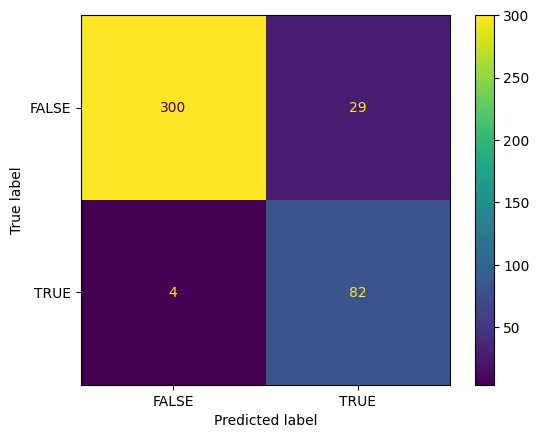

In [14]:
X_train = train2["text_input"].values
y_train = train2["y"].values
X_val = val["text_input"].values
y_val = val["y"].values
X_test = test["text_input"].values
y_test = test["y"].values

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1,
    ))
])

baseline.fit(X_train, y_train)

val_pred = baseline.predict(X_val)
test_pred = baseline.predict(X_test)

print("VAL report")
print(classification_report(y_val, val_pred, target_names=["FALSE","TRUE"]))
print("TEST report")
print(classification_report(y_test, test_pred, target_names=["FALSE","TRUE"]))

cm = confusion_matrix(y_test, test_pred)
ConfusionMatrixDisplay(cm, display_labels=["FALSE","TRUE"]).plot()
plt.show()

In [15]:
scorer = make_scorer(f1_score, average="macro")

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "tfidf__sublinear_tf": [True, False],
    "clf__C": [0.1, 0.3, 1.0, 3.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear"],  # stable for text
}

grid = GridSearchCV(
    estimator=baseline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

print("Best CV score:", grid.best_score_)
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best CV score: 0.8290211338102876
Best params:
  clf__C: 3.0
  clf__penalty: l2
  clf__solver: liblinear
  tfidf__max_df: 0.95
  tfidf__min_df: 5
  tfidf__ngram_range: (1, 2)
  tfidf__sublinear_tf: True


C:\Users\alex_\.conda\envs\test_env\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


VAL report (best model)
              precision    recall  f1-score   support

       FALSE       0.97      0.95      0.96       259
        TRUE       0.82      0.89      0.85        72

    accuracy                           0.93       331
   macro avg       0.89      0.92      0.91       331
weighted avg       0.94      0.93      0.93       331

TEST report (best model)
              precision    recall  f1-score   support

       FALSE       0.99      0.94      0.96       329
        TRUE       0.80      0.95      0.87        86

    accuracy                           0.94       415
   macro avg       0.89      0.94      0.91       415
weighted avg       0.95      0.94      0.94       415



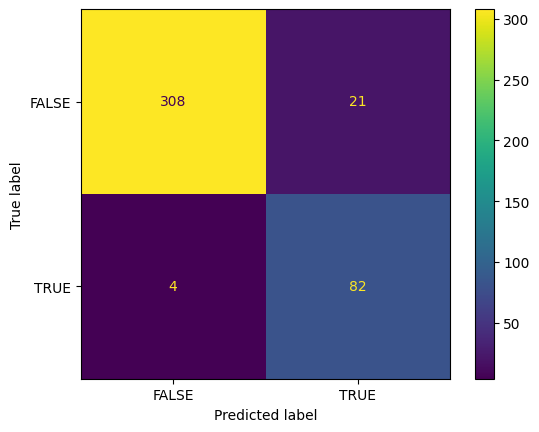

In [16]:
best_model = grid.best_estimator_

val_pred = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

print("VAL report (best model)")
print(classification_report(y_val, val_pred, target_names=["FALSE","TRUE"]))

print("TEST report (best model)")
print(classification_report(y_test, test_pred, target_names=["FALSE","TRUE"]))

cm = confusion_matrix(y_test, test_pred)
ConfusionMatrixDisplay(cm, display_labels=["FALSE","TRUE"]).plot()
plt.show()

## TF-IDF + SVM

TEST report (SVM calibrated, threshold=0.5)
              precision    recall  f1-score   support

       FALSE       0.98      0.96      0.97       329
        TRUE       0.86      0.91      0.88        86

    accuracy                           0.95       415
   macro avg       0.92      0.93      0.92       415
weighted avg       0.95      0.95      0.95       415



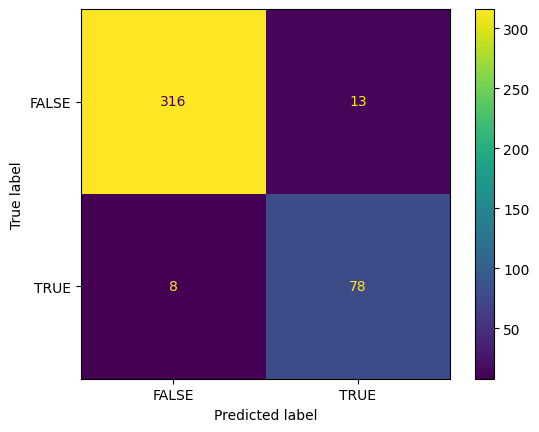

In [17]:
svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
    )),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(class_weight="balanced"),
        method="sigmoid",
        cv=3,
    ))
])

svm.fit(X_train, y_train)
test_proba = svm.predict_proba(X_test)[:,1]
test_pred2 = (test_proba >= 0.5).astype(int)

print("TEST report (SVM calibrated, threshold=0.5)")
print(classification_report(y_test, test_pred2, target_names=["FALSE","TRUE"]))

cm2 = confusion_matrix(y_test, test_pred2)
ConfusionMatrixDisplay(cm2, display_labels=["FALSE","TRUE"]).plot()
plt.show()

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best CV score: 0.8654063068553525
Best params:
  clf__estimator__C: 1.0
  clf__estimator__class_weight: None
  tfidf__max_df: 0.95
  tfidf__min_df: 1
  tfidf__ngram_range: (1, 1)
TEST report (best SVM)
              precision    recall  f1-score   support

       FALSE       0.97      0.97      0.97       329
        TRUE       0.89      0.88      0.89        86

    accuracy                           0.95       415
   macro avg       0.93      0.93      0.93       415
weighted avg       0.95      0.95      0.95       415



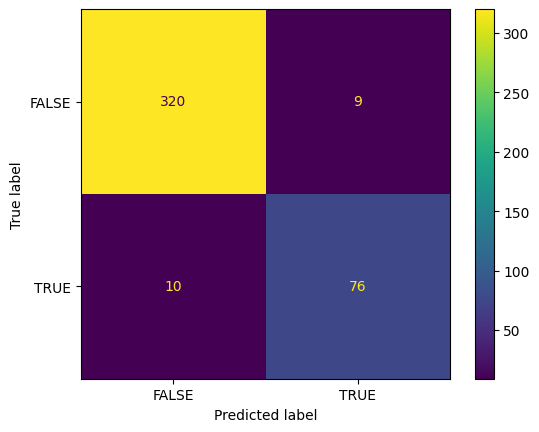

In [18]:
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        sublinear_tf=True,
    )),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(),
        method="sigmoid",
        cv=3,
    ))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "clf__estimator__C": [0.1, 0.3, 1.0, 3.0],
    "clf__estimator__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

print("Best CV score:", grid.best_score_)
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_svm = grid.best_estimator_

test_proba = best_svm.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("TEST report (best SVM)")
print(classification_report(y_test, test_pred, target_names=["FALSE","TRUE"]))

cm = confusion_matrix(y_test, test_pred)
ConfusionMatrixDisplay(cm, display_labels=["FALSE","TRUE"]).plot()
plt.show()

## Transformer Classifier

In [22]:
MODEL_NAME = "readerbench/RoBERT-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

def make_hf_dataset(df: pd.DataFrame) -> Dataset:
    df2 = df[["text_input","y"]].copy()
    df2["y"] = df2["y"].astype(int)
    return Dataset.from_pandas(
        df2.rename(columns={"text_input":"text","y":"label"}),
        preserve_index=False
    )

train_ds = make_hf_dataset(train2)
val_ds = make_hf_dataset(val)
test_ds = make_hf_dataset(test)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

collator = DataCollatorWithPadding(tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1322 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision_true": precision, "recall_true": recall, "f1_true": f1, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir="./veracity_roberta",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=100,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\alex_\.conda\envs\test_env\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision True,Recall True,F1 True,F1 Macro
1,0.225000,0.112157,0.969789,0.942857,0.916667,0.929577,0.955173
2,0.039800,0.117840,0.975831,0.957143,0.930556,0.943662,0.964139
3,0.026200,0.138071,0.972810,0.943662,0.930556,0.937063,0.959861


TrainOutput(global_step=498, training_loss=0.08485508838810595, metrics={'train_runtime': 9694.9191, 'train_samples_per_second': 0.409, 'train_steps_per_second': 0.051, 'total_flos': 1043498445557760.0, 'train_loss': 0.08485508838810595, 'epoch': 3.0})

In [24]:
print("VAL metrics:")
print(trainer.evaluate(val_ds))

print("\nTEST metrics:")
print(trainer.evaluate(test_ds))

VAL metrics:


{'eval_loss': 0.11784008890390396, 'eval_accuracy': 0.9758308157099698, 'eval_precision_true': 0.9571428571428572, 'eval_recall_true': 0.9305555555555556, 'eval_f1_true': 0.9436619718309859, 'eval_f1_macro': 0.9641386782231853, 'eval_runtime': 14.7566, 'eval_samples_per_second': 22.431, 'eval_steps_per_second': 2.846, 'epoch': 3.0}

TEST metrics:
{'eval_loss': 0.03829849511384964, 'eval_accuracy': 0.9903614457831326, 'eval_precision_true': 0.9659090909090909, 'eval_recall_true': 0.9883720930232558, 'eval_f1_true': 0.9770114942528736, 'eval_f1_macro': 0.9854569666386319, 'eval_runtime': 18.2718, 'eval_samples_per_second': 22.713, 'eval_steps_per_second': 2.846, 'epoch': 3.0}


              precision    recall  f1-score   support

       FALSE       1.00      0.99      0.99       329
        TRUE       0.97      0.99      0.98        86

    accuracy                           0.99       415
   macro avg       0.98      0.99      0.99       415
weighted avg       0.99      0.99      0.99       415



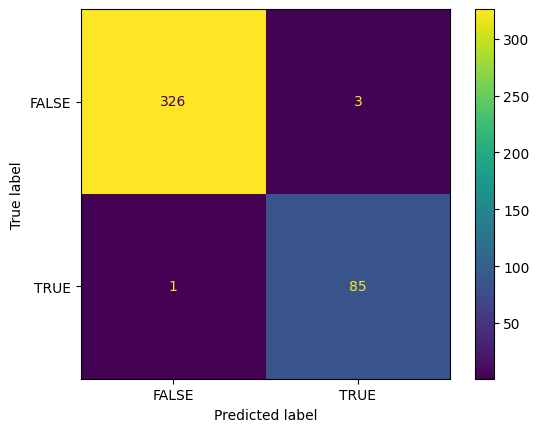

In [25]:
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids
probs_true = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
y_pred = (probs_true >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["FALSE","TRUE"]))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["FALSE","TRUE"]).plot()
plt.show()


## Save models

In [26]:
OUT_DATA = PROJECT_ROOT / "UnifiedBinary"
OUT_MODELS = PROJECT_ROOT / "models"
OUT_DATA.mkdir(exist_ok=True)
OUT_MODELS.mkdir(exist_ok=True)

train2.to_csv(OUT_DATA / "train.csv", index=False, encoding="utf-8")
val.to_csv(OUT_DATA / "val.csv", index=False, encoding="utf-8")
test.to_csv(OUT_DATA / "test.csv", index=False, encoding="utf-8")

joblib.dump(best_model, OUT_MODELS / "veracity_tfidf_logreg.joblib")
joblib.dump(best_svm, OUT_MODELS / "veracity_tfidf_svm_calibrated.joblib")

TRANS_DIR = OUT_MODELS / "veracity_roberta"
trainer.save_model(str(TRANS_DIR))
tokenizer.save_pretrained(str(TRANS_DIR))

meta = {
    "model_name": MODEL_NAME,
    "label_map": {"0": "FALSE", "1": "TRUE"},
    "input_field": "text_input",
    "notes": "text_input uses long text if available (>=200 chars), else short; header includes [SHORT]/[LONG].",
}
(TRANS_DIR / "meta.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

print("Wrote:", OUT_DATA)
print("Wrote:", OUT_MODELS)

Wrote: UnifiedBinary
Wrote: models
